In [ ]:
import pandas as pd

Found 201 snapshots.


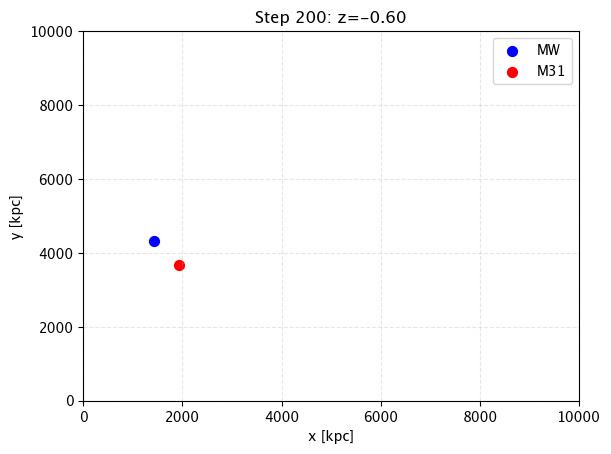

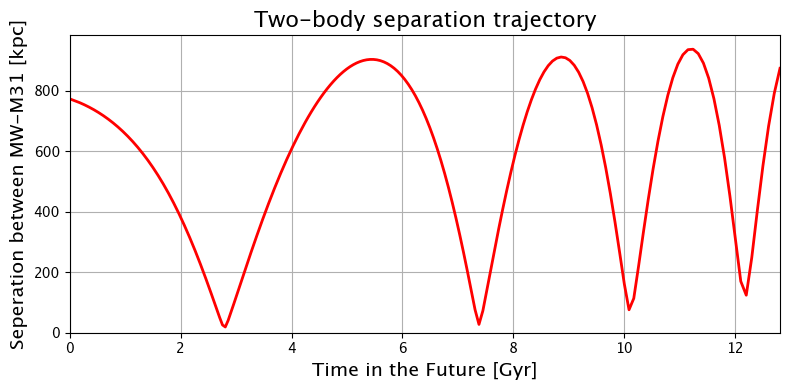

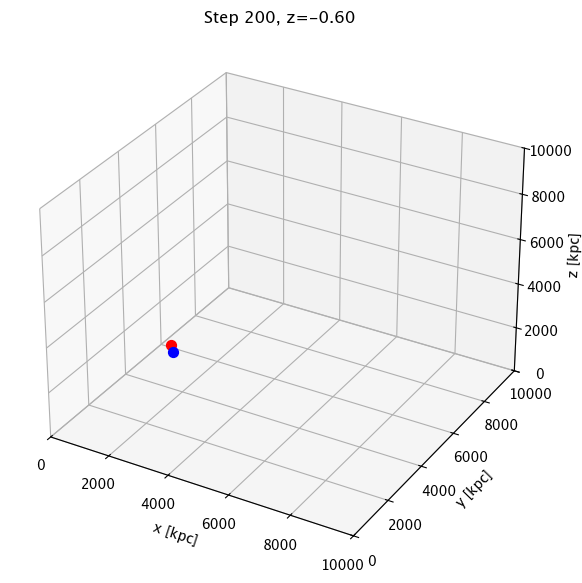

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pathlib import Path
from astropy.constants import pc

# Set up path
path = '/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College 2022-2025/Yr 4/Zhao/PySCo/test_2body/galaxy_infall/mond/output_infall_0.1'
base = Path(path)
snapshots = sorted(base.glob("output_*/particles_*.parquet"))
print(f"Found {len(snapshots)} snapshots.")

# Load positions in BU
positions = []
for snap in snapshots:
    df = pd.read_parquet(snap)
    pos = df[["x", "y", "z"]].values  # shape (2, 3)
    positions.append(pos)
positions = np.array(positions)  # shape: (n_snapshots, 2, 3)

def BU_to_kpc(x_BU, z, boxlen, H0=70.):
    # BU = a * boxlen * 100 / H0
    mpc_to_km = 1e3 * pc.value  #   Mpc -> km
    H0 = H0 / mpc_to_km  # km/s/Mpc -> 1/s
    aexp = 1./(1.+z)
    BU_to_km = aexp * boxlen * 100 / H0
    BU_to_kpc  = BU_to_km / pc.value 
    x_kpc = x_BU * BU_to_kpc
    return x_kpc

def find_boxlen(l_proper, H0=70., aexp=1.):
    """
    Calculate the box length in Mpc/h given Universe proper length in Mpc.
    
    Parameters:
    - l_proper: Universe's proper length in Mpc.
    - H0: Hubble constant in km/s/Mpc (default is 70).
    - aexp: Scale factor (default is 1, present time).
    
    Returns:
    - Box length in Mpc/h (comoving unit).
    """
    boxlen = l_proper / aexp * H0 / 100.0  # Convert to Mpc/h
    if boxlen < 1.0:
        raise ValueError("Box length must be at least 1 Mpc/h to avoid periodic boundary effects.")
    return boxlen

boxlen = find_boxlen(10)
z_out = np.linspace(-0.01, -0.6, 200).tolist() 
z_out.insert(0, 0.0)

pos_kpc = positions.copy()
for i in range(len(z_out)):
    pos_kpc[i,:,:] = BU_to_kpc(positions[i,:,:], z_out[i], boxlen)


fig, ax = plt.subplots()
colors = ['blue', 'red']

lim = 10e3 # boxsize in kpc

def update(i):
    ax.clear()
    ax.set_xlim(0, lim)
    ax.set_ylim(0, lim)
    #ax.set_title(f"Step {i}")
    ax.set_title(f"Step {i}: z={z_out[i]:.2f}")
    ax.set_xlabel("x [kpc]")
    ax.set_ylabel("y [kpc]")
    ax.grid(True, linestyle='--', alpha=0.3)
    
    for pid in range(2):
        n = 0
        #ax.scatter(pos_kpc[i, pid, 0], pos_kpc[i, pid, 1], color=colors[pid], s=50)
        ax.scatter(pos_kpc[i, pid, 0], pos_kpc[i, pid, 1], color=colors[pid], s=50)
        if n == 0:
            ax.legend(['MW', 'M31'])
        n += 1
        

ani = animation.FuncAnimation(fig, update, frames=len(positions), interval=30)
ani.save(f"{path}/trajectory.gif", writer="pillow")
plt.show()




# --- Simulation info ---
from astropy.cosmology import FlatLambdaCDM
H0 = 70.0
Om0 = 0.0016912641756876147
cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

# --- Convert z to lookahead time in Gyr ---
t_now = cosmo.age(0).value
lookahead_times = cosmo.age(z_out).value - t_now  # Time after present in Gyr

# Compute separation in 3D over time
separations = np.linalg.norm(pos_kpc[:, 0, :] - pos_kpc[:, 1, :], axis=1)  # in kpc

# --- Plot trajectory ---
plt.figure(figsize=(8, 4))
plt.plot(lookahead_times[:len(separations)], separations, 'r', linewidth=2)
"""plt.grid(True)
plt.xlabel("Time in the Future [Gyr]", fontsize=14)
plt.ylabel("Seperation between MW-M31 [kpc]", fontsize=14)
plt.title("Two-body separation", fontsize=16)
plt.ylim(0)
plt.xlim(0, np.max(lookahead_times))
plt.savefig(f"{path}/separation.png", dpi=300)
plt.show()"""

plt.xlabel("Time in the Future [Gyr]", fontsize=14)
plt.ylabel("Seperation between MW-M31 [kpc]", fontsize=14)
plt.title("Two-body separation trajectory", fontsize=16)
plt.xlim(0, np.max(lookahead_times))
plt.ylim(0)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{path}/trajectory_separation.png", dpi=300)
plt.show()


# --- 3D Animation Setup ---
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
colors = ['red', 'blue']

def update(i):
    ax.clear()
    ax.set_xlim(0, lim)
    ax.set_ylim(0, lim)
    ax.set_zlim(0, lim)
    ax.set_title(f"Step {i}, z={z_out[i]:.2f}")
    ax.set_xlabel("x [kpc]")
    ax.set_ylabel("y [kpc]")
    ax.set_zlabel("z [kpc]")
    ax.grid(True, linestyle='--', alpha=0.3)

    for pid in range(2):
        ax.scatter(pos_kpc[i, pid, 0], pos_kpc[i, pid, 1], pos_kpc[i, pid, 2],
                   color=colors[pid], s=50, label='MW' if pid == 0 else 'M31')

    # Add legend once
    if i == 0:
        ax.legend(loc='upper right')

ani = animation.FuncAnimation(fig, update, frames=len(pos_kpc), interval=30)
ani.save(f"{path}/trajectory_3d.gif", writer="pillow")
plt.show()


In [33]:
def BUps_to_kmps(v_BUs, z, boxlen=7.):
    aexp = 1/(1+z)
    return v_BUs * (boxlen * 100.0 / aexp)
def BU_to_kpc(x_BU, z, boxsize_mpc=10.0):
    """Convert position from BU to kpc for a given redshift z."""
    aexp = 1.0 / (1.0 + z)
    return x_BU * (boxsize_mpc * 1000.0 * aexp)

# Loop over snapshots and convert

for snap, z in zip(snapshots, z_out):
    df = pd.read_parquet(snap)
    
    # Build a new dataframe with converted units only
    df_conv = pd.DataFrame({
        "x_kpc": BU_to_kpc(df["x"].values, z),
        "y_kpc": BU_to_kpc(df["y"].values, z),
        "z_kpc": BU_to_kpc(df["z"].values, z),
        "vx_km_s": BUps_to_kmps(df["vx"].values, z),
        "vy_km_s": BUps_to_kmps(df["vy"].values, z),
        "vz_km_s": BUps_to_kmps(df["vz"].values, z)
    })
    display(df)
    #display(df_conv)


,x,y,z,vx,vy,vz
0,0.126296,0.057426,0.119687,-0.060025,0.082186,-0.053863
1,0.088496,0.118626,0.091387,0.026261,-0.035957,0.023565


,x,y,z,vx,vy,vz
0,0.125668,0.058293,0.119127,-0.064984,0.090573,-0.057535
1,0.088768,0.118245,0.091630,0.027982,-0.039935,0.024906


,x,y,z,vx,vy,vz
0,0.125471,0.058568,0.118953,-0.066517,0.093192,-0.058658
1,0.088853,0.118124,0.091706,0.028517,-0.041166,0.025327


,x,y,z,vx,vy,vz
0,0.125269,0.058853,0.118775,-0.068081,0.095876,-0.059796
1,0.088939,0.117998,0.091782,0.029065,-0.042422,0.025759


,x,y,z,vx,vy,vz
0,0.125061,0.059146,0.118593,-0.069676,0.098629,-0.060951
1,0.089028,0.117868,0.091861,0.029627,-0.043705,0.026203


,x,y,z,vx,vy,vz
0,0.124847,0.059449,0.118407,-0.071302,0.101452,-0.062123
1,0.089118,0.117734,0.091941,0.030202,-0.045015,0.026660


,x,y,z,vx,vy,vz
0,0.124628,0.059761,0.118216,-0.072961,0.104348,-0.063312
1,0.089211,0.117595,0.092022,0.030791,-0.046354,0.027129


,x,y,z,vx,vy,vz
0,0.124404,0.060083,0.118022,-0.074654,0.107321,-0.064519
1,0.089306,0.117452,0.092106,0.031395,-0.047721,0.027611


,x,y,z,vx,vy,vz
0,0.124173,0.060416,0.117823,-0.076380,0.110372,-0.065744
1,0.089402,0.117304,0.092191,0.032014,-0.049120,0.028108


,x,y,z,vx,vy,vz
0,0.123936,0.060759,0.117619,-0.078141,0.113505,-0.066988
1,0.089501,0.117151,0.092278,0.032650,-0.050550,0.028618


,x,y,z,vx,vy,vz
0,0.123694,0.061112,0.117412,-0.079937,0.116723,-0.068250
1,0.089603,0.116994,0.092366,0.033302,-0.052014,0.029144


,x,y,z,vx,vy,vz
0,0.123444,0.061477,0.117199,-0.081769,0.120029,-0.069532
1,0.089706,0.116831,0.092457,0.033971,-0.053512,0.029685


,x,y,z,vx,vy,vz
0,0.123189,0.061853,0.116982,-0.083638,0.123426,-0.070834
1,0.089813,0.116663,0.092550,0.034658,-0.055046,0.030242


,x,y,z,vx,vy,vz
0,0.122926,0.062242,0.116761,-0.085544,0.126918,-0.072155
1,0.089921,0.116490,0.092644,0.035364,-0.056617,0.030815


,x,y,z,vx,vy,vz
0,0.122657,0.062642,0.116534,-0.087489,0.130508,-0.073497
1,0.090032,0.116312,0.092741,0.036090,-0.058227,0.031405


,x,y,z,vx,vy,vz
0,0.122381,0.063055,0.116303,-0.089472,0.134200,-0.074860
1,0.090146,0.116127,0.092840,0.036836,-0.059878,0.032013


,x,y,z,vx,vy,vz
0,0.122098,0.063481,0.116066,-0.091494,0.137997,-0.076245
1,0.090263,0.115937,0.092941,0.037603,-0.061570,0.032639


,x,y,z,vx,vy,vz
0,0.121807,0.063920,0.115824,-0.093558,0.141902,-0.077651
1,0.090382,0.115741,0.093045,0.038393,-0.063306,0.033284


,x,y,z,vx,vy,vz
0,0.121509,0.064374,0.115577,-0.095663,0.145918,-0.079081
1,0.090504,0.115539,0.093151,0.039206,-0.065086,0.033948


,x,y,z,vx,vy,vz
0,0.121203,0.064841,0.115325,-0.097811,0.150050,-0.080533
1,0.090629,0.115330,0.093259,0.040044,-0.066912,0.034633


,x,y,z,vx,vy,vz
0,0.120890,0.065324,0.115068,-0.100003,0.154299,-0.082009
1,0.090758,0.115115,0.093370,0.040908,-0.068785,0.035338


,x,y,z,vx,vy,vz
0,0.120568,0.065821,0.114804,-0.102240,0.158670,-0.083510
1,0.090889,0.114894,0.093484,0.041799,-0.070707,0.036065


,x,y,z,vx,vy,vz
0,0.120238,0.066335,0.114536,-0.104523,0.163167,-0.085035
1,0.091024,0.114665,0.093600,0.042719,-0.072679,0.036814


,x,y,z,vx,vy,vz
0,0.119900,0.066864,0.114261,-0.106854,0.167792,-0.086587
1,0.091162,0.114429,0.093719,0.043669,-0.074701,0.037585


,x,y,z,vx,vy,vz
0,0.119553,0.067411,0.113980,-0.109234,0.172550,-0.088165
1,0.091304,0.114186,0.093841,0.044650,-0.076776,0.038380


,x,y,z,vx,vy,vz
0,0.119198,0.067974,0.113694,-0.111663,0.177443,-0.089770
1,0.091449,0.113935,0.093966,0.045665,-0.078904,0.039199


,x,y,z,vx,vy,vz
0,0.118833,0.068556,0.113401,-0.114145,0.182475,-0.091403
1,0.091599,0.113677,0.094094,0.046714,-0.081086,0.040043


,x,y,z,vx,vy,vz
0,0.118458,0.069156,0.113102,-0.116678,0.187648,-0.093064
1,0.091752,0.113410,0.094225,0.047800,-0.083323,0.040911


,x,y,z,vx,vy,vz
0,0.118075,0.069775,0.112796,-0.119265,0.192966,-0.094755
1,0.091909,0.113135,0.094360,0.048923,-0.085615,0.041805


,x,y,z,vx,vy,vz
0,0.117681,0.070413,0.112484,-0.121907,0.198430,-0.096475
1,0.092071,0.112852,0.094497,0.050087,-0.087963,0.042725


,x,y,z,vx,vy,vz
0,0.117278,0.071072,0.112166,-0.124605,0.204041,-0.098225
1,0.092237,0.112560,0.094639,0.051291,-0.090365,0.043671


,x,y,z,vx,vy,vz
0,0.116864,0.071752,0.111840,-0.127358,0.209802,-0.100006
1,0.092407,0.112259,0.094784,0.052539,-0.092823,0.044643


,x,y,z,vx,vy,vz
0,0.116440,0.072453,0.111508,-0.130169,0.215711,-0.101817
1,0.092582,0.111949,0.094933,0.053830,-0.095334,0.045642


,x,y,z,vx,vy,vz
0,0.116004,0.073176,0.111168,-0.133036,0.221768,-0.103658
1,0.092763,0.111630,0.095085,0.055166,-0.097897,0.046667


,x,y,z,vx,vy,vz
0,0.115558,0.073922,0.110821,-0.135959,0.22797,-0.105530
1,0.092948,0.111301,0.095242,0.056548,-0.10051,0.047719


,x,y,z,vx,vy,vz
0,0.115101,0.074691,0.110466,-0.138939,0.234313,-0.107430
1,0.093138,0.110962,0.095402,0.057977,-0.103170,0.048796


,x,y,z,vx,vy,vz
0,0.114632,0.075485,0.110104,-0.141972,0.240792,-0.109358
1,0.093335,0.110613,0.095567,0.059452,-0.105874,0.049898


,x,y,z,vx,vy,vz
0,0.114151,0.076303,0.109735,-0.145058,0.247399,-0.111312
1,0.093536,0.110253,0.095736,0.060973,-0.108618,0.051025


,x,y,z,vx,vy,vz
0,0.113658,0.077146,0.109357,-0.148192,0.254123,-0.113290
1,0.093744,0.109884,0.095910,0.062539,-0.111394,0.052175


,x,y,z,vx,vy,vz
0,0.113153,0.078014,0.108972,-0.151372,0.260952,-0.115287
1,0.093958,0.109503,0.096088,0.064147,-0.114197,0.053346


,x,y,z,vx,vy,vz
0,0.112635,0.078909,0.108578,-0.154591,0.267869,-0.117300
1,0.094177,0.109112,0.096270,0.065797,-0.117019,0.054536


,x,y,z,vx,vy,vz
0,0.112104,0.079831,0.108176,-0.157844,0.274854,-0.119323
1,0.094404,0.108709,0.096458,0.067483,-0.119850,0.055743


,x,y,z,vx,vy,vz
0,0.111561,0.080780,0.107766,-0.161122,0.281882,-0.121350
1,0.094637,0.108296,0.096650,0.069202,-0.122679,0.056962


,x,y,z,vx,vy,vz
0,0.111004,0.081756,0.107347,-0.164416,0.288925,-0.123372
1,0.094876,0.107872,0.096847,0.070948,-0.125493,0.058191


,x,y,z,vx,vy,vz
0,0.110434,0.082759,0.106921,-0.167713,0.295950,-0.125379
1,0.095123,0.107436,0.097048,0.072715,-0.128278,0.059423


,x,y,z,vx,vy,vz
0,0.109851,0.083791,0.106485,-0.170999,0.302920,-0.127361
1,0.095376,0.106990,0.097255,0.074495,-0.131018,0.060654


,x,y,z,vx,vy,vz
0,0.109254,0.084849,0.106042,-0.174258,0.309792,-0.129302
1,0.095637,0.106532,0.097467,0.076279,-0.133693,0.061876


,x,y,z,vx,vy,vz
0,0.108644,0.085935,0.105590,-0.177470,0.316519,-0.131189
1,0.095904,0.106064,0.097684,0.078058,-0.136285,0.063083


,x,y,z,vx,vy,vz
0,0.108021,0.087048,0.105131,-0.180613,0.323046,-0.133002
1,0.096179,0.105586,0.097905,0.079820,-0.138771,0.064266


,x,y,z,vx,vy,vz
0,0.107385,0.088187,0.104663,-0.183662,0.329317,-0.134724
1,0.096461,0.105097,0.098132,0.081552,-0.141127,0.065416


,x,y,z,vx,vy,vz
0,0.106737,0.089352,0.104188,-0.186587,0.335269,-0.136331
1,0.096749,0.104598,0.098363,0.083241,-0.143328,0.066523


,x,y,z,vx,vy,vz
0,0.106076,0.090541,0.103706,-0.189359,0.340834,-0.137800
1,0.097045,0.104091,0.098599,0.084872,-0.145346,0.067575


,x,y,z,vx,vy,vz
0,0.105403,0.091753,0.103217,-0.191943,0.345943,-0.139106
1,0.097347,0.103574,0.098839,0.086429,-0.147153,0.068563


,x,y,z,vx,vy,vz
0,0.104719,0.092986,0.102723,-0.194304,0.350522,-0.140222
1,0.097656,0.103050,0.099083,0.087895,-0.148719,0.069472


,x,y,z,vx,vy,vz
0,0.104024,0.094240,0.102223,-0.196404,0.354498,-0.141121
1,0.097971,0.102519,0.099332,0.089253,-0.150013,0.070293


,x,y,z,vx,vy,vz
0,0.103320,0.095510,0.101718,-0.198203,0.357810,-0.141774
1,0.098292,0.101982,0.099584,0.090486,-0.151013,0.071012


,x,y,z,vx,vy,vz
0,0.102608,0.096796,0.101210,-0.199662,0.360418,-0.142157
1,0.098618,0.101440,0.099839,0.091576,-0.151701,0.071618


,x,y,z,vx,vy,vz
0,0.101889,0.098095,0.100699,-0.200745,0.362289,-0.142244
1,0.098948,0.100895,0.100097,0.092507,-0.152064,0.072101


,x,y,z,vx,vy,vz
0,0.101163,0.099404,0.100186,-0.201419,0.363398,-0.142017
1,0.099283,0.100346,0.100358,0.093265,-0.152089,0.072452


,x,y,z,vx,vy,vz
0,0.100434,0.100720,0.099673,-0.201660,0.363726,-0.141459
1,0.099622,0.099796,0.100621,0.093839,-0.151768,0.072666


,x,y,z,vx,vy,vz
0,0.099702,0.102040,0.099161,-0.201445,0.363264,-0.140562
1,0.099963,0.099246,0.100885,0.094220,-0.151097,0.072736


,x,y,z,vx,vy,vz
0,0.098968,0.103362,0.09865,-0.200761,0.362009,-0.139320
1,0.100307,0.098697,0.10115,0.094401,-0.150072,0.072662


,x,y,z,vx,vy,vz
0,0.098236,0.104683,0.098143,-0.19960,0.359968,-0.137732
1,0.100653,0.098150,0.101415,0.09438,-0.148697,0.072442


,x,y,z,vx,vy,vz
0,0.097506,0.106000,0.097641,-0.197961,0.357154,-0.135806
1,0.100999,0.097607,0.101681,0.094155,-0.146976,0.072079


,x,y,z,vx,vy,vz
0,0.096780,0.107310,0.097144,-0.195851,0.353591,-0.133552
1,0.101345,0.097069,0.101945,0.093729,-0.144919,0.071578


,x,y,z,vx,vy,vz
0,0.096060,0.108611,0.096655,-0.193281,0.349308,-0.130985
1,0.101691,0.096537,0.102209,0.093106,-0.142541,0.070943


,x,y,z,vx,vy,vz
0,0.095347,0.109899,0.096174,-0.190271,0.344341,-0.128126
1,0.102035,0.096013,0.102471,0.092294,-0.139857,0.070184


,x,y,z,vx,vy,vz
0,0.094645,0.111172,0.095702,-0.186845,0.338733,-0.124999
1,0.102377,0.095497,0.102731,0.091301,-0.136889,0.069308


,x,y,z,vx,vy,vz
0,0.093953,0.112427,0.095241,-0.183031,0.332530,-0.121630
1,0.102717,0.094991,0.102988,0.090139,-0.133661,0.068328


,x,y,z,vx,vy,vz
0,0.093273,0.113663,0.094791,-0.178862,0.325782,-0.118050
1,0.103053,0.094496,0.103243,0.088820,-0.130201,0.067254


,x,y,z,vx,vy,vz
0,0.092607,0.114877,0.094353,-0.174381,0.318539,-0.114286
1,0.103385,0.094012,0.103494,0.087360,-0.126538,0.066096


,x,y,z,vx,vy,vz
0,0.091957,0.116068,0.093928,-0.169631,0.310852,-0.110370
1,0.103712,0.093540,0.103742,0.085775,-0.122704,0.064867


,x,y,z,vx,vy,vz
0,0.091322,0.117233,0.093517,-0.164658,0.302770,-0.106328
1,0.104035,0.093082,0.103986,0.084082,-0.118732,0.063576


,x,y,z,vx,vy,vz
0,0.090704,0.118371,0.093119,-0.159501,0.294344,-0.102190
1,0.104352,0.092637,0.104226,0.082297,-0.114656,0.062233


,x,y,z,vx,vy,vz
0,0.090104,0.119481,0.092736,-0.154198,0.285621,-0.097982
1,0.104663,0.092206,0.104461,0.080433,-0.110508,0.060849


,x,y,z,vx,vy,vz
0,0.089522,0.12056,0.092368,-0.148786,0.276644,-0.093728
1,0.104968,0.09179,0.104692,0.078503,-0.106323,0.059432


,x,y,z,vx,vy,vz
0,0.088959,0.121609,0.092015,-0.143293,0.267454,-0.089450
1,0.105267,0.091388,0.104918,0.076519,-0.102132,0.057992


,x,y,z,vx,vy,vz
0,0.088415,0.122626,0.091677,-0.137748,0.258093,-0.085166
1,0.105559,0.091001,0.105140,0.074493,-0.097959,0.056535


,x,y,z,vx,vy,vz
0,0.087891,0.123611,0.091355,-0.132172,0.248598,-0.080890
1,0.105845,0.090629,0.105357,0.072432,-0.093822,0.055068


,x,y,z,vx,vy,vz
0,0.087387,0.124561,0.091048,-0.126584,0.239004,-0.076634
1,0.106123,0.090271,0.105569,0.070346,-0.089733,0.053594


,x,y,z,vx,vy,vz
0,0.086902,0.125478,0.090756,-0.120995,0.229345,-0.072407
1,0.106395,0.089928,0.105776,0.068240,-0.085697,0.052119


,x,y,z,vx,vy,vz
0,0.086437,0.126361,0.090480,-0.115415,0.219647,-0.068212
1,0.106659,0.089599,0.105978,0.066120,-0.081710,0.050644


,x,y,z,vx,vy,vz
0,0.085993,0.127208,0.090219,-0.109847,0.209930,-0.064052
1,0.106915,0.089284,0.106174,0.063987,-0.077767,0.049171


,x,y,z,vx,vy,vz
0,0.085569,0.128021,0.089973,-0.104293,0.200209,-0.059926
1,0.107165,0.088984,0.106366,0.061845,-0.073861,0.047699


,x,y,z,vx,vy,vz
0,0.085165,0.128798,0.089743,-0.098755,0.190496,-0.055837
1,0.107406,0.088698,0.106553,0.059694,-0.069984,0.046230


,x,y,z,vx,vy,vz
0,0.084782,0.129539,0.089528,-0.093232,0.180798,-0.051782
1,0.107640,0.088426,0.106735,0.057535,-0.066133,0.044763


,x,y,z,vx,vy,vz
0,0.084419,0.130244,0.089329,-0.087722,0.171120,-0.047760
1,0.107867,0.088169,0.106911,0.055368,-0.062299,0.043296


,x,y,z,vx,vy,vz
0,0.084077,0.130914,0.089144,-0.082225,0.161462,-0.043770
1,0.108085,0.087925,0.107083,0.053193,-0.058480,0.041829


,x,y,z,vx,vy,vz
0,0.083756,0.131547,0.088976,-0.076736,0.151824,-0.039810
1,0.108296,0.087697,0.107249,0.051009,-0.054670,0.040362


,x,y,z,vx,vy,vz
0,0.083455,0.132143,0.088822,-0.071253,0.142202,-0.035876
1,0.108498,0.087483,0.107410,0.048814,-0.050865,0.038892


,x,y,z,vx,vy,vz
0,0.083176,0.132703,0.088684,-0.065772,0.132589,-0.031966
1,0.108693,0.087283,0.107565,0.046608,-0.047062,0.037418


,x,y,z,vx,vy,vz
0,0.082918,0.133226,0.088561,-0.060287,0.122980,-0.028075
1,0.108879,0.087098,0.107715,0.044389,-0.043256,0.035939


,x,y,z,vx,vy,vz
0,0.082682,0.133711,0.088454,-0.054794,0.113368,-0.024199
1,0.109057,0.086929,0.107860,0.042155,-0.039442,0.034454


,x,y,z,vx,vy,vz
0,0.082467,0.134159,0.088362,-0.049286,0.103742,-0.020332
1,0.109226,0.086774,0.107999,0.039905,-0.035616,0.032959


,x,y,z,vx,vy,vz
0,0.082275,0.134569,0.088286,-0.043759,0.094092,-0.016471
1,0.109387,0.086634,0.108132,0.037636,-0.031775,0.031455


,x,y,z,vx,vy,vz
0,0.082104,0.13494,0.088225,-0.038204,0.084407,-0.012609
1,0.109538,0.08651,0.108260,0.035346,-0.027914,0.029939


,x,y,z,vx,vy,vz
0,0.081956,0.135272,0.088181,-0.032617,0.074677,-0.008741
1,0.109681,0.086402,0.108382,0.033033,-0.024029,0.028410


,x,y,z,vx,vy,vz
0,0.081831,0.135565,0.088152,-0.026990,0.064888,-0.004862
1,0.109815,0.086309,0.108498,0.030694,-0.020116,0.026865


,x,y,z,vx,vy,vz
0,0.081730,0.135818,0.088140,-0.021316,0.055028,-0.000966
1,0.109939,0.086233,0.108608,0.028327,-0.016170,0.025304


,x,y,z,vx,vy,vz
0,0.081651,0.136029,0.088144,-0.015587,0.045085,0.002954
1,0.110054,0.086173,0.108711,0.025929,-0.012187,0.023724


,x,y,z,vx,vy,vz
0,0.110159,0.086129,0.108809,0.023497,-0.008163,0.022123
1,0.081597,0.136200,0.088165,-0.009796,0.035043,0.006904


,x,y,z,vx,vy,vz
0,0.110254,0.086103,0.108900,0.019305,-0.001009,0.019306
1,0.081568,0.136328,0.088203,-0.005748,0.027907,0.009532


,x,y,z,vx,vy,vz
0,0.110324,0.086121,0.108974,0.013318,0.009337,0.015252
1,0.081548,0.136438,0.088247,-0.003469,0.023715,0.010823


,x,y,z,vx,vy,vz
0,0.110368,0.086183,0.109030,0.007239,0.019833,0.011145
1,0.081538,0.136531,0.088296,-0.001155,0.019465,0.012127


,x,y,z,vx,vy,vz
0,0.110386,0.086292,0.109070,0.001060,0.030497,0.006978
1,0.081538,0.136606,0.088351,0.001199,0.015149,0.013450


,x,y,z,vx,vy,vz
0,0.110377,0.086448,0.109091,-0.005228,0.041349,0.002745
1,0.081549,0.136662,0.088412,0.003597,0.010759,0.014793


,x,y,z,vx,vy,vz
0,0.110341,0.086652,0.109094,-0.011633,0.052414,-0.001559
1,0.081570,0.136700,0.088480,0.006044,0.006290,0.016162


,x,y,z,vx,vy,vz
0,0.110276,0.086906,0.109077,-0.018165,0.063715,-0.005942
1,0.081602,0.136717,0.088554,0.008544,0.001733,0.017560


,x,y,z,vx,vy,vz
0,0.110181,0.087211,0.109041,-0.024837,0.075279,-0.010412
1,0.081645,0.136715,0.088634,0.011104,-0.002918,0.018993


,x,y,z,vx,vy,vz
0,0.110057,0.087570,0.108985,-0.031659,0.087134,-0.014975
1,0.081700,0.136691,0.088721,0.013728,-0.007674,0.020465


,x,y,z,vx,vy,vz
0,0.109901,0.087983,0.108909,-0.038644,0.099307,-0.019640
1,0.081766,0.136647,0.088815,0.016423,-0.012541,0.021981


,x,y,z,vx,vy,vz
0,0.109713,0.088453,0.108811,-0.045806,0.111830,-0.024417
1,0.081846,0.136580,0.088917,0.019196,-0.017532,0.023548


,x,y,z,vx,vy,vz
0,0.109491,0.088982,0.108690,-0.053158,0.124731,-0.029314
1,0.081938,0.136490,0.089026,0.022052,-0.022656,0.025172


,x,y,z,vx,vy,vz
0,0.109236,0.089572,0.108547,-0.060717,0.138039,-0.034343
1,0.082044,0.136376,0.089142,0.024998,-0.027925,0.026860


,x,y,z,vx,vy,vz
0,0.108944,0.090226,0.108381,-0.068500,0.151783,-0.039514
1,0.082163,0.136238,0.089268,0.028042,-0.033351,0.028620


,x,y,z,vx,vy,vz
0,0.108615,0.090947,0.108190,-0.076524,0.165990,-0.044839
1,0.082298,0.136074,0.089402,0.031191,-0.038946,0.030460


,x,y,z,vx,vy,vz
0,0.108248,0.091736,0.107973,-0.084808,0.180682,-0.050330
1,0.082447,0.135884,0.089545,0.034450,-0.044726,0.032388


,x,y,z,vx,vy,vz
0,0.107840,0.092598,0.107730,-0.093370,0.195882,-0.055999
1,0.082612,0.135666,0.089698,0.037827,-0.050704,0.034416


,x,y,z,vx,vy,vz
0,0.107391,0.093534,0.107459,-0.102229,0.211606,-0.061860
1,0.082794,0.135418,0.089861,0.041328,-0.056897,0.036552


,x,y,z,vx,vy,vz
0,0.106898,0.094549,0.107159,-0.111402,0.227861,-0.067924
1,0.082993,0.135141,0.090035,0.044958,-0.063321,0.038807


,x,y,z,vx,vy,vz
0,0.106359,0.095646,0.106829,-0.120904,0.244642,-0.074202
1,0.083211,0.134832,0.090220,0.048722,-0.069986,0.041193


,x,y,z,vx,vy,vz
0,0.105772,0.096826,0.106468,-0.130750,0.261938,-0.080703
1,0.083447,0.134489,0.090418,0.052621,-0.076895,0.043721


,x,y,z,vx,vy,vz
0,0.105136,0.098095,0.106075,-0.140950,0.279722,-0.087435
1,0.083703,0.134113,0.090629,0.056656,-0.084047,0.046402


,x,y,z,vx,vy,vz
0,0.104448,0.099454,0.105647,-0.151508,0.297953,-0.094401
1,0.083979,0.133700,0.090854,0.060823,-0.091434,0.049246


,x,y,z,vx,vy,vz
0,0.103706,0.100907,0.105184,-0.162418,0.316574,-0.101599
1,0.084277,0.133249,0.091094,0.065113,-0.099039,0.052260


,x,y,z,vx,vy,vz
0,0.102908,0.102457,0.104683,-0.173664,0.335498,-0.109018
1,0.084597,0.132760,0.091350,0.069513,-0.106836,0.055447


,x,y,z,vx,vy,vz
0,0.102051,0.104104,0.104145,-0.185207,0.354608,-0.116635
1,0.084939,0.132231,0.091622,0.073997,-0.114779,0.058803


,x,y,z,vx,vy,vz
0,0.101134,0.105852,0.103567,-0.196981,0.373741,-0.124410
1,0.085305,0.131661,0.091913,0.078531,-0.122805,0.062314


,x,y,z,vx,vy,vz
0,0.100156,0.10770,0.102948,-0.208884,0.392681,-0.132280
1,0.085695,0.13105,0.092222,0.083060,-0.130823,0.065955


,x,y,z,vx,vy,vz
0,0.099115,0.109648,0.102288,-0.220765,0.411149,-0.140152
1,0.086108,0.130397,0.092550,0.087514,-0.138711,0.069684


,x,y,z,vx,vy,vz
0,0.098011,0.111694,0.101586,-0.232416,0.428787,-0.147894
1,0.086545,0.129702,0.092899,0.091798,-0.146310,0.073442


,x,y,z,vx,vy,vz
0,0.096846,0.113834,0.100844,-0.24356,0.445158,-0.155333
1,0.087004,0.128968,0.093267,0.09579,-0.153420,0.077146


,x,y,z,vx,vy,vz
0,0.095622,0.116061,0.100063,-0.253855,0.459744,-0.162247
1,0.087485,0.128197,0.093655,0.099344,-0.159803,0.080694


,x,y,z,vx,vy,vz
0,0.094344,0.118365,0.099245,-0.262900,0.471952,-0.168374
1,0.087984,0.127393,0.094063,0.102289,-0.165179,0.083963


,x,y,z,vx,vy,vz
0,0.093018,0.120736,0.098395,-0.270261,0.481138,-0.173423
1,0.088498,0.126561,0.094487,0.104442,-0.169246,0.086819


,x,y,z,vx,vy,vz
0,0.091653,0.123155,0.097518,-0.275559,0.486645,-0.177100
1,0.089023,0.125708,0.094927,0.105645,-0.171690,0.089129


,x,y,z,vx,vy,vz
0,0.090261,0.125604,0.096623,-0.278524,0.487866,-0.179144
1,0.089555,0.124843,0.095379,0.105789,-0.172219,0.090767


,x,y,z,vx,vy,vz
0,0.088853,0.128061,0.095717,-0.279010,0.484462,-0.179369
1,0.090087,0.123977,0.095840,0.104815,-0.170675,0.091639


,x,y,z,vx,vy,vz
0,0.087441,0.130500,0.094810,-0.277006,0.476473,-0.177690
1,0.090614,0.123119,0.096305,0.102724,-0.167081,0.091702


,x,y,z,vx,vy,vz
0,0.086039,0.13290,0.093912,-0.272626,0.464169,-0.174134
1,0.091130,0.12228,0.096771,0.099575,-0.161574,0.090963


,x,y,z,vx,vy,vz
0,0.084658,0.135238,0.093033,-0.266079,0.447958,-0.168828
1,0.091631,0.121469,0.097234,0.095473,-0.154355,0.089472


,x,y,z,vx,vy,vz
0,0.083309,0.137496,0.092180,-0.257631,0.428338,-0.161987
1,0.092110,0.120696,0.097689,0.090548,-0.145668,0.087319


,x,y,z,vx,vy,vz
0,0.082001,0.139656,0.091362,-0.247568,0.405848,-0.153873
1,0.092564,0.119967,0.098134,0.084947,-0.135772,0.084616


,x,y,z,vx,vy,vz
0,0.080743,0.141703,0.090585,-0.236171,0.381023,-0.144741
1,0.092990,0.119289,0.098566,0.078811,-0.124925,0.081473


,x,y,z,vx,vy,vz
0,0.079540,0.143626,0.089854,-0.223692,0.354364,-0.134825
1,0.093385,0.118666,0.098983,0.072272,-0.113366,0.077988


,x,y,z,vx,vy,vz
0,0.078400,0.145414,0.089173,-0.210346,0.326309,-0.124321
1,0.093747,0.118102,0.099383,0.065443,-0.101303,0.074248


,x,y,z,vx,vy,vz
0,0.077326,0.147061,0.088545,-0.196309,0.297225,-0.113380
1,0.094074,0.117599,0.099765,0.058417,-0.088906,0.070318


,x,y,z,vx,vy,vz
0,0.076322,0.148560,0.087973,-0.181714,0.267410,-0.102112
1,0.094366,0.117161,0.100127,0.051263,-0.076302,0.066248


,x,y,z,vx,vy,vz
0,0.075392,0.149907,0.087459,-0.166659,0.237089,-0.090588
1,0.094620,0.116787,0.100470,0.044031,-0.063581,0.062074


,x,y,z,vx,vy,vz
0,0.074539,0.151096,0.087004,-0.151209,0.206419,-0.078849
1,0.094837,0.116481,0.100792,0.036751,-0.050805,0.057818


,x,y,z,vx,vy,vz
0,0.095015,0.116241,0.101092,0.029432,-0.038011,0.053488
1,0.073766,0.152126,0.086611,-0.135408,0.175496,-0.066915


,x,y,z,vx,vy,vz
0,0.095155,0.116070,0.10137,0.017258,-0.016042,0.044769
1,0.073075,0.152994,0.08628,-0.123620,0.152567,-0.058861


,x,y,z,vx,vy,vz
0,0.095202,0.116068,0.101578,0.000090,0.015215,0.031547
1,0.072422,0.153785,0.085971,-0.115921,0.137727,-0.054745


,x,y,z,vx,vy,vz
0,0.095155,0.116237,0.101714,-0.017362,0.046623,0.018050
1,0.071808,0.154499,0.085682,-0.107979,0.122779,-0.050502


,x,y,z,vx,vy,vz
0,0.095011,0.116581,0.101776,-0.035148,0.078236,0.004226
1,0.071235,0.155134,0.085416,-0.099777,0.107742,-0.046113


,x,y,z,vx,vy,vz
0,0.094766,0.117103,0.101761,-0.053334,0.110140,-0.009996
1,0.070705,0.155690,0.085172,-0.091295,0.092621,-0.041556


,x,y,z,vx,vy,vz
0,0.094417,0.117807,0.101665,-0.071994,0.142444,-0.024695
1,0.070220,0.156164,0.084954,-0.082507,0.077404,-0.036804


,x,y,z,vx,vy,vz
0,0.093961,0.118696,0.101484,-0.091210,0.175274,-0.039972
1,0.069783,0.156555,0.084761,-0.073386,0.062049,-0.031826


,x,y,z,vx,vy,vz
0,0.093391,0.119778,0.101215,-0.111069,0.208765,-0.055939
1,0.069395,0.156861,0.084596,-0.063895,0.046488,-0.026585


,x,y,z,vx,vy,vz
0,0.092704,0.121058,0.100851,-0.131662,0.243035,-0.072723
1,0.069061,0.157080,0.084461,-0.054000,0.030632,-0.021044


,x,y,z,vx,vy,vz
0,0.091894,0.122542,0.100387,-0.153078,0.278158,-0.090450
1,0.068782,0.157208,0.084357,-0.043665,0.014391,-0.015162


,x,y,z,vx,vy,vz
0,0.090953,0.124239,0.099816,-0.175391,0.314138,-0.109241
1,0.068562,0.157244,0.084288,-0.032856,-0.002308,-0.008910


,x,y,z,vx,vy,vz
0,0.089876,0.126156,0.099131,-0.198646,0.350871,-0.129178
1,0.068404,0.157181,0.084255,-0.021551,-0.019509,-0.002272


,x,y,z,vx,vy,vz
0,0.088655,0.128299,0.098322,-0.222793,0.388099,-0.150242
1,0.068313,0.157017,0.084261,-0.009766,-0.037174,0.004723


,x,y,z,vx,vy,vz
0,0.087283,0.130673,0.097382,-0.247656,0.425377,-0.172260
1,0.068291,0.156748,0.084310,0.002432,-0.055155,0.011988


,x,y,z,vx,vy,vz
0,0.085756,0.133278,0.096305,-0.272937,0.462038,-0.194894
1,0.068342,0.156371,0.084402,0.014928,-0.073174,0.019371


,x,y,z,vx,vy,vz
0,0.084070,0.136112,0.095087,-0.298169,0.497126,-0.217582
1,0.068467,0.155886,0.084538,0.027530,-0.090798,0.026642


,x,y,z,vx,vy,vz
0,0.082225,0.139166,0.093728,-0.322666,0.529348,-0.239482
1,0.068668,0.155296,0.084718,0.039950,-0.107420,0.033472


,x,y,z,vx,vy,vz
0,0.080225,0.142419,0.092234,-0.34546,0.557021,-0.259518
1,0.068944,0.154606,0.084937,0.05177,-0.122252,0.039447


,x,y,z,vx,vy,vz
0,0.078084,0.145841,0.090618,-0.365302,0.578098,-0.276545
1,0.069289,0.153830,0.085191,0.062450,-0.134350,0.044119


,x,y,z,vx,vy,vz
0,0.075821,0.149388,0.088900,-0.380772,0.590349,-0.289475
1,0.069697,0.152986,0.085469,0.071374,-0.142700,0.047050


,x,y,z,vx,vy,vz
0,0.073466,0.153001,0.087107,-0.390503,0.591667,-0.297435
1,0.070155,0.152099,0.085761,0.077939,-0.146330,0.047860


,x,y,z,vx,vy,vz
0,0.071056,0.156607,0.085270,-0.393454,0.580424,-0.299965
1,0.070648,0.151201,0.086053,0.081681,-0.144452,0.046343


,x,y,z,vx,vy,vz
0,0.068636,0.160126,0.083424,-0.389172,0.556362,-0.297158
1,0.071158,0.150326,0.086330,0.082376,-0.136824,0.042521


,x,y,z,vx,vy,vz
0,0.066249,0.163478,0.081600,-0.377827,0.520993,-0.289599
1,0.071665,0.149511,0.086578,0.080068,-0.124005,0.036623


,x,y,z,vx,vy,vz
0,0.063940,0.166600,0.079825,-0.360055,0.476752,-0.278119
1,0.072153,0.148785,0.086785,0.074993,-0.107048,0.029001


,x,y,z,vx,vy,vz
0,0.061747,0.169439,0.078122,-0.336781,0.426238,-0.263601
1,0.072603,0.148173,0.086941,0.067492,-0.087135,0.020043


,x,y,z,vx,vy,vz
0,0.059702,0.171962,0.076508,-0.309163,0.371744,-0.246802
1,0.073002,0.147690,0.087037,0.057980,-0.065333,0.010095


,x,y,z,vx,vy,vz
0,0.057832,0.174145,0.074997,-0.278359,0.314963,-0.228265
1,0.073337,0.147346,0.087068,0.046892,-0.042445,-0.000578


,x,y,z,vx,vy,vz
0,0.056156,0.175974,0.073599,-0.245205,0.257034,-0.208333
1,0.073599,0.147150,0.087029,0.034568,-0.019021,-0.011795


,x,y,z,vx,vy,vz
0,0.054688,0.177440,0.072325,-0.210198,0.198639,-0.187201
1,0.073780,0.147103,0.086916,0.021247,0.004599,-0.023443


,x,y,z,vx,vy,vz
0,0.053444,0.178536,0.071183,-0.173577,0.140126,-0.164944
1,0.073873,0.147210,0.086726,0.007077,0.028238,-0.035460


,x,y,z,vx,vy,vz
0,0.052434,0.179258,0.070183,-0.135393,0.081618,-0.141557
1,0.073871,0.147471,0.086455,-0.007870,0.051838,-0.047819


,x,y,z,vx,vy,vz
0,0.051674,0.179601,0.069333,-0.095567,0.023100,-0.116977
1,0.073769,0.147889,0.086100,-0.023574,0.075419,-0.060529


,x,y,z,vx,vy,vz
0,0.051178,0.179560,0.068644,-0.053932,-0.035500,-0.091092
1,0.073560,0.148465,0.085657,-0.040058,0.099042,-0.073614


,x,y,z,vx,vy,vz
0,0.050961,0.179128,0.068127,-0.010277,-0.094241,-0.063756
1,0.073238,0.149203,0.085124,-0.057373,0.122783,-0.087108


,x,y,z,vx,vy,vz
0,0.051043,0.178300,0.067794,0.035626,-0.153057,-0.034808
1,0.072794,0.150104,0.084495,-0.075579,0.146725,-0.101042


,x,y,z,vx,vy,vz
0,0.051442,0.177070,0.067661,0.083949,-0.211617,-0.004111
1,0.072222,0.151174,0.083766,-0.094703,0.170948,-0.115432


,x,y,z,vx,vy,vz
0,0.052180,0.175436,0.067740,0.134680,-0.269147,0.028371
1,0.071513,0.152417,0.082933,-0.114686,0.195479,-0.130242


,x,y,z,vx,vy,vz
0,0.053278,0.173403,0.068048,0.187355,-0.324169,0.062444
1,0.070659,0.153837,0.081992,-0.135263,0.220151,-0.145342


,x,y,z,vx,vy,vz
0,0.054751,0.170990,0.068598,0.240584,-0.374246,0.097452
1,0.069658,0.155436,0.080940,-0.155788,0.244205,-0.160428


,x,y,z,vx,vy,vz
0,0.056601,0.168236,0.069395,0.291522,-0.415820,0.131990
1,0.068508,0.157208,0.079777,-0.175021,0.265906,-0.174898


,x,y,z,vx,vy,vz
0,0.058805,0.165210,0.070434,0.335641,-0.444415,0.163700
1,0.067224,0.159132,0.078509,-0.191030,0.282731,-0.187745


,x,y,z,vx,vy,vz
0,0.061300,0.162015,0.071687,0.367347,-0.455154,0.189501
1,0.065834,0.161166,0.077149,-0.201430,0.292051,-0.197629


,x,y,z,vx,vy,vz
0,0.063983,0.158795,0.073106,0.381521,-0.443798,0.206347
1,0.064385,0.163248,0.075723,-0.204077,0.291802,-0.203220


,x,y,z,vx,vy,vz
0,0.066715,0.155718,0.074617,0.375848,-0.408470,0.212305
1,0.062938,0.165307,0.074265,-0.198241,0.281114,-0.203660


,x,y,z,vx,vy,vz
0,0.069355,0.152958,0.076140,0.351676,-0.351397,0.207295
1,0.061552,0.167266,0.072812,-0.185029,0.260862,-0.198883


,x,y,z,vx,vy,vz
0,0.071777,0.150662,0.077601,0.312640,-0.278242,0.192760
1,0.060275,0.169062,0.071402,-0.166524,0.233303,-0.189471


,x,y,z,vx,vy,vz
0,0.073886,0.148927,0.078935,0.262892,-0.195243,0.170660
1,0.059138,0.170648,0.070065,-0.144716,0.200922,-0.176236


,x,y,z,vx,vy,vz
0,0.075614,0.147814,0.080092,0.205828,-0.107325,0.142703
1,0.058162,0.171995,0.068828,-0.120901,0.165748,-0.159922


,x,y,z,vx,vy,vz
0,0.057360,0.173085,0.067713,-0.095707,0.129203,-0.141081
1,0.076912,0.147353,0.081033,0.143683,-0.017690,0.110030


In [34]:
path = '/Users/c./Library/Mobile Documents/com~apple~CloudDocs/Imperial College 2022-2025/Yr 4/Zhao/PySCo/test_2body/galaxy_infall/newton/output_infall_0.1'
base = Path(path)
snapshots = sorted(base.glob("output_*/particles_*.parquet"))

# Loop over snapshots and convert

for snap, z in zip(snapshots, z_out):
    df = pd.read_parquet(snap)
    
    # Build a new dataframe with converted units only
    df_conv = pd.DataFrame({
        "x_kpc": BU_to_kpc(df["x"].values, z),
        "y_kpc": BU_to_kpc(df["y"].values, z),
        "z_kpc": BU_to_kpc(df["z"].values, z),
        "vx_km_s": BUps_to_kmps(df["vx"].values, z),
        "vy_km_s": BUps_to_kmps(df["vy"].values, z),
        "vz_km_s": BUps_to_kmps(df["vz"].values, z)
    })
    display(df)
    #display(df_conv)


,x,y,z,vx,vy,vz
0,0.126296,0.057426,0.119687,-0.060025,0.082186,-0.053863
1,0.088496,0.118626,0.091387,0.026261,-0.035957,0.023565


,x,y,z,vx,vy,vz
0,0.125692,0.058253,0.119145,-0.060141,0.082390,-0.053948
1,0.088760,0.118264,0.091624,0.026312,-0.036046,0.023602


,x,y,z,vx,vy,vz
0,0.124440,0.059969,0.118023,-0.060399,0.082857,-0.054136
1,0.089307,0.117514,0.092115,0.026425,-0.036250,0.023684


,x,y,z,vx,vy,vz
0,0.123157,0.061731,0.116873,-0.060690,0.083405,-0.054345
1,0.089869,0.116743,0.092618,0.026552,-0.036490,0.023776


,x,y,z,vx,vy,vz
0,0.121838,0.063544,0.115693,-0.061019,0.084052,-0.054577
1,0.090446,0.115949,0.093134,0.026696,-0.036773,0.023877


,x,y,z,vx,vy,vz
0,0.120483,0.065414,0.114482,-0.061390,0.084816,-0.054835
1,0.091039,0.115132,0.093664,0.026858,-0.037107,0.023990


,x,y,z,vx,vy,vz
0,0.119088,0.067344,0.113237,-0.061811,0.085715,-0.055121
1,0.091649,0.114287,0.094209,0.027042,-0.037501,0.024115


,x,y,z,vx,vy,vz
0,0.117651,0.069341,0.111956,-0.062287,0.086768,-0.055438
1,0.092278,0.113413,0.094769,0.027251,-0.037961,0.024254


,x,y,z,vx,vy,vz
0,0.116167,0.071413,0.110637,-0.062823,0.087988,-0.055785
1,0.092927,0.112507,0.095346,0.027485,-0.038495,0.024406


,x,y,z,vx,vy,vz
0,0.114634,0.073567,0.109277,-0.063422,0.089386,-0.056161
1,0.093598,0.111564,0.095941,0.027747,-0.039107,0.024570


,x,y,z,vx,vy,vz
0,0.113047,0.075812,0.107874,-0.064081,0.090965,-0.056559
1,0.094292,0.110582,0.096555,0.028035,-0.039797,0.024745


,x,y,z,vx,vy,vz
0,0.111401,0.078157,0.106424,-0.064793,0.092714,-0.056968
1,0.095012,0.109556,0.097189,0.028347,-0.040562,0.024923


,x,y,z,vx,vy,vz
0,0.109693,0.080611,0.104926,-0.065542,0.094603,-0.057365
1,0.095759,0.108483,0.097845,0.028675,-0.041389,0.025097


,x,y,z,vx,vy,vz
0,0.107919,0.083183,0.103377,-0.066299,0.096580,-0.057718
1,0.096535,0.107357,0.098523,0.029006,-0.042254,0.025251


,x,y,z,vx,vy,vz
0,0.106075,0.085883,0.101776,-0.067019,0.098564,-0.057981
1,0.097342,0.106176,0.099223,0.029321,-0.043122,0.025366


,x,y,z,vx,vy,vz
0,0.104159,0.088715,0.100124,-0.067642,0.100444,-0.058092
1,0.098181,0.104937,0.099946,0.029594,-0.043944,0.025415


,x,y,z,vx,vy,vz
0,0.102170,0.091682,0.098423,-0.068089,0.102077,-0.057978
1,0.099051,0.103639,0.100690,0.029789,-0.044658,0.025364


,x,y,z,vx,vy,vz
0,0.100111,0.094783,0.096678,-0.068269,0.103303,-0.057554
1,0.099951,0.102283,0.101453,0.029868,-0.045193,0.025178


,x,y,z,vx,vy,vz
0,0.097988,0.098011,0.094898,-0.068091,0.103985,-0.056749
1,0.100880,0.100870,0.102232,0.029789,-0.045491,0.024825


,x,y,z,vx,vy,vz
0,0.095809,0.101354,0.093093,-0.067484,0.104052,-0.055520
1,0.101834,0.099408,0.103022,0.029524,-0.045520,0.024287


,x,y,z,vx,vy,vz
0,0.093585,0.104801,0.091276,-0.066424,0.103495,-0.053889
1,0.102806,0.097900,0.103816,0.029060,-0.045276,0.023573


,x,y,z,vx,vy,vz
0,0.091329,0.108335,0.089460,-0.064942,0.102362,-0.051939
1,0.103793,0.096354,0.104611,0.028412,-0.044781,0.022720


,x,y,z,vx,vy,vz
0,0.089053,0.111945,0.087653,-0.063136,0.100741,-0.049788
1,0.104789,0.094775,0.105401,0.027622,-0.044071,0.021779


,x,y,z,vx,vy,vz
0,0.086765,0.115620,0.085861,-0.061135,0.098751,-0.047565
1,0.105790,0.093167,0.106185,0.026747,-0.043201,0.020807


,x,y,z,vx,vy,vz
0,0.084468,0.119354,0.084086,-0.059069,0.096528,-0.045389
1,0.106795,0.091533,0.106962,0.025843,-0.042228,0.019854


,x,y,z,vx,vy,vz
0,0.082162,0.123144,0.082324,-0.057046,0.094207,-0.043346
1,0.107804,0.089875,0.107732,0.024958,-0.041213,0.018961


,x,y,z,vx,vy,vz
0,0.079842,0.126995,0.080571,-0.055141,0.091905,-0.041489
1,0.108819,0.088191,0.108499,0.024124,-0.040206,0.018148


,x,y,z,vx,vy,vz
0,0.077501,0.130914,0.078818,-0.053388,0.089696,-0.039828
1,0.109843,0.086476,0.109266,0.023357,-0.039239,0.017422


,x,y,z,vx,vy,vz
0,0.075130,0.134912,0.077057,-0.051787,0.087611,-0.038347
1,0.110881,0.084727,0.110036,0.022657,-0.038327,0.016774


,x,y,z,vx,vy,vz
0,0.072719,0.139005,0.075278,-0.050327,0.085655,-0.037022
1,0.111935,0.082937,0.110814,0.022018,-0.037471,0.016194


,x,y,z,vx,vy,vz
0,0.070257,0.143206,0.073473,-0.048990,0.083818,-0.035825
1,0.113012,0.081099,0.111604,0.021433,-0.036667,0.015670
